In [ ]:
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans


  Cloning https://github.com/tensorflow/cleverhans.git to /tmp/pip-install-01afgulv/cleverhans_375dd899dc4b4c96ac231a3d80686227
  Running command git clone -q https://github.com/tensorflow/cleverhans.git /tmp/pip-install-01afgulv/cleverhans_375dd899dc4b4c96ac231a3d80686227


In [ ]:
from keras.datasets import mnist
from keras import Sequential
from keras.layers import Dense, BatchNormalization
from keras import backend
import keras
import tensorflow as tf
import cleverhans
print("\n Tensorflow Version: " + tf.__version__)
print("\n Cleverhans Version: " + cleverhans.__version__)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from cleverhans.tf2.attacks import fast_gradient_method as fgsm

#from cleverhans.attacks import FastGradientMethod, MadryEtAl, DeepFool, CarliniWagnerL2


 Tensorflow Version: 2.7.0

 Cleverhans Version: 4.0.0-242afd7ec8f9546baeb1168438446ce1


In [ ]:
import tensorflow.keras as keras

mnist = tf.keras.datasets.mnist

#this dataset is already split into training and testing sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train.shape = ", x_train.shape)
print("y_train.shape = ", y_train.shape)
print("x_test.shape = ", x_test.shape)
print("y_test.shape = ", y_test.shape)


# The labels are currently a single array of values
# We need to convert this into a one-hot encoded array
# i.e., 5 -> [0,0,0,0,0,1,0,0,0,0]
# We'll see why in a few cells

y_train_categorical = keras.utils.to_categorical(y_train)
y_test_categorical = keras.utils.to_categorical(y_test)
print("y_train.shape = ", y_train.shape)
print("y_test.shape = ", y_test.shape)


x_train.shape =  (60000, 28, 28, 1)
y_train.shape =  (60000,)
x_test.shape =  (10000, 28, 28, 1)
y_test.shape =  (10000,)
y_train.shape =  (60000,)
y_test.shape =  (10000,)


In [ ]:
def create_simple_cnn():
  input_shape = (28,28,1)

  network = keras.Sequential()
  network.add(keras.layers.Conv2D(10, input_shape=input_shape, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')) #The more conV layer we add, we can extract more features from images---mycomment
  network.add(keras.layers.Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  network.add(keras.layers.MaxPool2D(pool_size=(2,2)))
  network.add(keras.layers.Dropout(0.25))
  network.add(keras.layers.Flatten())
  network.add(keras.layers.Dense(500, activation='relu'))
  network.add(keras.layers.Dense(10, activation='softmax'))
  return network

network = create_simple_cnn()
network.compile(optimizer="adam", #standard optimizer
                    loss="categorical_crossentropy", #standard for multi-class problems
                    metrics=["accuracy"])
network.summary()



simple_cnn_history = network.fit(x=x_train, 
                                    y=y_train_categorical, 
                                    epochs=3,
                                    validation_split=0.1)

# Evaluate the model.
# We'll just evaluate accuracy for now. Later we'll abstract this to its own function
# and evaluate accuracy, f1, and area under the ROC curve 
predictions_simple_cnn = network.predict(x_test)
# Convert the categorical predictions back to labels for calculating metrics
predictions_simple_cnn = [np.argmax(pred) for pred in predictions_simple_cnn]
m = tf.keras.metrics.Accuracy()
m.update_state(y_test, predictions_simple_cnn)
print("Accuracy of trained model: ",m.result().numpy())

network.save('MNIST_cnn.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 10)        100       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 50)        4550      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 50)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 50)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9800)              0         
                                                                 
 dense_2 (Dense)             (None, 500)               4900500   
                                                      

In [ ]:


from keras.models import load_model
model = load_model('MNIST_cnn.h5')


Choose Random Attack Image


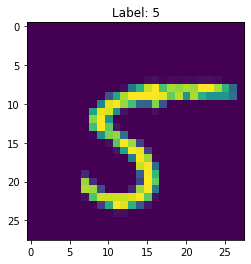

In [ ]:
random_index = np.random.randint(x_test.shape[0])

original_image = x_test[random_index]
original_image = tf.convert_to_tensor(original_image.reshape((1,28,28))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

original_label = y_test[random_index]
original_label = np.reshape(original_label, (1,)).astype('int64') # Give label proper shape and type for cleverhans

#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(original_image, (28,28)))
plt.title("Label: {}".format(original_label[0]))

plt.show()

**Non Targeted FGSM ATTACK**

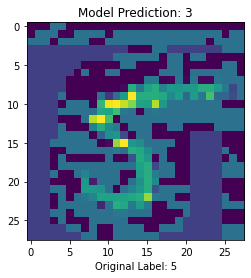

In [ ]:
epsilon = 0.3

adv_example_untargeted_label = fgsm.fast_gradient_method(model, original_image, epsilon, np.inf, targeted=False)

adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)

#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(adv_example_untargeted_label, (28,28)))
plt.title("Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred)))
plt.xlabel("Original Label: {}".format(original_label[0]))

plt.show()

# **Targeted FGSM Attack**

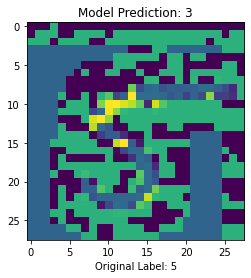

In [ ]:
epsilon = 0.9
# The target value may have to be changed to work, some images are more easily missclassified as different labels
target = 4

target_label = np.reshape(target, (1,)).astype('int64') # Give target label proper size and dtype to feed through

adv_example_targeted_label = fgsm.fast_gradient_method(model, original_image, epsilon, np.inf, y=target_label, targeted=True)

adv_example_targeted_label_pred = model.predict(adv_example_targeted_label)

#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(adv_example_targeted_label, (28,28)))
plt.title("Model Prediction: {}".format(np.argmax(adv_example_targeted_label_pred)))
plt.xlabel("Original Label: {}".format(original_label[0]))

plt.show()

# **Generate Adversarial Data to Check model accuracy**


In [ ]:
epsilon = 0.4
adversarial_data = fgsm.fast_gradient_method(model,x_test, epsilon, norm=np.inf)
predictions_adversarial = model.predict(adversarial_data)
# Convert the categorical predictions back to labels for calculating metrics
predictions_adversarial_data = [np.argmax(pred) for pred in predictions_adversarial]
m = tf.keras.metrics.Accuracy()
m.update_state(y_test, predictions_adversarial_data)
print("Model accuracy after attack",m.result().numpy())

Model accuracy after attack 0.0691


# **Train the model with Adversarial Sample**

In [ ]:
epsilon = 0.2
adversarial_data_train = fgsm.fast_gradient_method(model,x_test, epsilon, norm=np.inf)
#adversarial_data_train = keras.utils.to_categorical(adversarial_data_train)
#print("adversarial_data.shape = ", adversarial_data_train.shape)
#print("adversarial_label.shape = ", y_test.shape)
model.fit(adversarial_data_train, y_test_categorical, epochs=2)


Epoch 1/2
313/313 [==============================] - 28s 89ms/step - loss: 0.1593 - accuracy: 0.9567
Epoch 2/2
313/313 [==============================] - 28s 88ms/step - loss: 0.0180 - accuracy: 0.9949


# **Test with Adversarial Examples**

In [ ]:
epsilon = 0.05
adversarial_data_test = fgsm.fast_gradient_method(model,x_test, epsilon, norm=np.inf)
predictions_adversarial_test = model.predict(adversarial_data_test)
# Convert the categorical predictions back to labels for calculating metrics
predictions_adversarial_data_test = [np.argmax(pred) for pred in predictions_adversarial_test]
m = tf.keras.metrics.Accuracy()
m.update_state(y_test, predictions_adversarial_data_test)
print("Model accuracy after attack",m.result().numpy())

Model accuracy after attack 0.8428


# **Test with Regular Examples**

In [ ]:
regular_data_test = model.predict(x_test)
# Convert the categorical predictions back to labels for calculating metrics
predictions = [np.argmax(pred) for pred in regular_data_test]
m = tf.keras.metrics.Accuracy()
m.update_state(y_test, predictions)
print(m.result().numpy())

0.9905
